Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


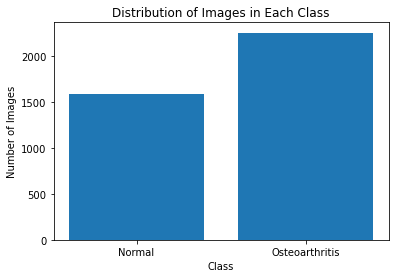

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-23 12:53:34.688081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 12:53:34.827092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 12:53:34.827131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 12:53:34.859270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 12:53:34.920285: I tensorflow/core/platform/cpu_feature_guar

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


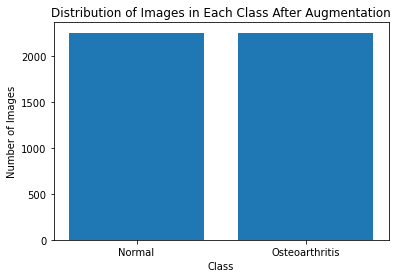

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1000 + [1] * 1000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1120
X_test size: 600
X_validation size: 280


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

# CNN+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
X_train = np.array(X_train) / 255.0  # Scale pixel values to [0, 1]
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 11s 308ms/step - loss: 0.8126 - accuracy: 0.5188 - val_loss: 0.6812 - val_accuracy: 0.6000
Epoch 2/50
35/35 [==============================] - 11s 320ms/step - loss: 0.6835 - accuracy: 0.5500 - val_loss: 0.6822 - val_accuracy: 0.5821
Epoch 3/50
35/35 [==============================] - 11s 318ms/step - loss: 0.6756 - accuracy: 0.5482 - val_loss: 0.6726 - val_accuracy: 0.5893
Epoch 4/50
35/35 [==============================] - 11s 318ms/step - loss: 0.6749 - accuracy: 0.5527 - val_loss: 0.6771 - val_accuracy: 0.5893
Epoch 5/50
35/35 [==============================] - 11s 318ms/step - loss: 0.6727 - accuracy: 0.5509 - val_loss: 0.6677 - val_accuracy: 0.5893
Epoch 6/50
35/35 [==============================] - 11s 317ms/step - loss: 0.6633 - accuracy: 0.5768 - val_loss: 0.6692 - val_accuracy: 0.6143
Epoch 7/50
35/35 [==============================] - 11s 320ms/step - loss: 0.6565 - accuracy: 0.5902 - val_loss: 0.6768 - val_accuracy: 0.5143

19/19 [==============================] - 1s 73ms/step


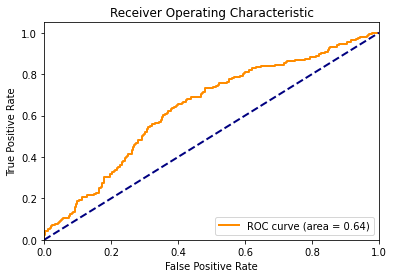

9/9 [==============================] - 1s 71ms/step - loss: 0.6472 - accuracy: 0.6179
Validation Loss: 0.6472493410110474
Validation Accuracy: 0.6178571581840515
Test Loss: 0.691376880123572
Inference Time (seconds): 1.5712497234344482
Test Accuracy: 0.6116666666666667
Confusion Matrix:
 [[209  93]
 [140 158]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.69      0.64       302
           1       0.63      0.53      0.58       298

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.61      0.61      0.61       600

ROC AUC Score: 0.6378727943464153
Metrics saved successfully


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 11s 315ms/step - loss: 0.6015 - accuracy: 0.6509 - val_loss: 0.6450 - val_accuracy: 0.6464
Epoch 2/100
35/35 [==============================] - 11s 315ms/step - loss: 0.5513 - accuracy: 0.7107 - val_loss: 0.6658 - val_accuracy: 0.6143
Epoch 3/100
35/35 [==============================] - 11s 313ms/step - loss: 0.5081 - accuracy: 0.7295 - val_loss: 0.7828 - val_accuracy: 0.6143
Epoch 4/100
35/35 [==============================] - 11s 313ms/step - loss: 0.5665 - accuracy: 0.6875 - val_loss: 0.6553 - val_accuracy: 0.6214
Epoch 5/100
35/35 [==============================] - 11s 315ms/step - loss: 0.5683 - accuracy: 0.6902 - val_loss: 0.6841 - val_accuracy: 0.6107
Epoch 6/100
35/35 [==============================] - 11s 315ms/step - loss: 0.5025 - accuracy: 0.7312 - val_loss: 0.6944 - val_accuracy: 0.6143
Training Time: 66.13834142684937 seconds


19/19 [==============================] - 1s 73ms/step


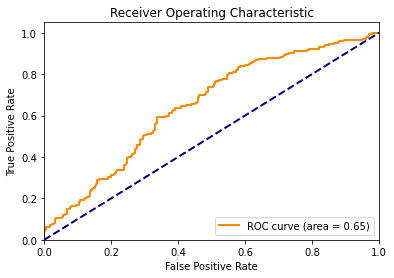

9/9 [==============================] - 1s 71ms/step - loss: 0.6450 - accuracy: 0.6464
Validation Loss: 0.6450279951095581
Validation Accuracy: 0.6464285850524902
Test Loss: 0.7000533779735961
Inference Time (seconds): 1.5376241207122803
Test Accuracy: 0.605
Confusion Matrix:
 [[202 100]
 [137 161]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       302
           1       0.62      0.54      0.58       298

    accuracy                           0.60       600
   macro avg       0.61      0.60      0.60       600
weighted avg       0.61      0.60      0.60       600

ROC AUC Score: 0.6484065958487044
Metrics saved successfully


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 11s 316ms/step - loss: 0.5524 - accuracy: 0.7089 - val_loss: 0.6668 - val_accuracy: 0.6643
Epoch 2/150
35/35 [==============================] - 11s 312ms/step - loss: 0.5107 - accuracy: 0.7330 - val_loss: 0.6828 - val_accuracy: 0.6143
Epoch 3/150
35/35 [==============================] - 11s 315ms/step - loss: 0.4744 - accuracy: 0.7598 - val_loss: 0.6791 - val_accuracy: 0.6357
Epoch 4/150
35/35 [==============================] - 11s 315ms/step - loss: 0.4640 - accuracy: 0.7679 - val_loss: 0.7147 - val_accuracy: 0.6286
Epoch 5/150
35/35 [==============================] - 11s 315ms/step - loss: 0.4255 - accuracy: 0.7991 - val_loss: 0.7355 - val_accuracy: 0.6750
Epoch 6/150
35/35 [==============================] - 11s 313ms/step - loss: 0.3907 - accuracy: 0.8268 - val_loss: 0.7258 - val_accuracy: 0.6500
Training Time: 66.09907078742981 seconds


19/19 [==============================] - 1s 73ms/step


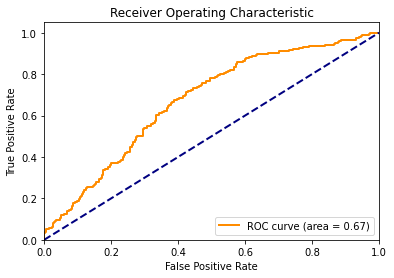

9/9 [==============================] - 1s 72ms/step - loss: 0.6668 - accuracy: 0.6643
Validation Loss: 0.6667701005935669
Validation Accuracy: 0.6642857193946838
Test Loss: 0.7101511590239902
Inference Time (seconds): 1.5289416313171387
Test Accuracy: 0.6383333333333333
Confusion Matrix:
 [[181 121]
 [ 96 202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.63       302
           1       0.63      0.68      0.65       298

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600

ROC AUC Score: 0.6721743188586159
Metrics saved successfully


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 11s 316ms/step - loss: 0.5128 - accuracy: 0.7473 - val_loss: 0.6917 - val_accuracy: 0.6143
Epoch 2/200
35/35 [==============================] - 11s 315ms/step - loss: 0.4793 - accuracy: 0.7554 - val_loss: 0.7433 - val_accuracy: 0.6571
Epoch 3/200
35/35 [==============================] - 11s 318ms/step - loss: 0.4853 - accuracy: 0.7446 - val_loss: 0.6937 - val_accuracy: 0.6143
Epoch 4/200
35/35 [==============================] - 11s 315ms/step - loss: 0.5427 - accuracy: 0.6991 - val_loss: 0.7150 - val_accuracy: 0.6250
Epoch 5/200
35/35 [==============================] - 11s 313ms/step - loss: 0.4343 - accuracy: 0.7884 - val_loss: 0.8201 - val_accuracy: 0.6357
Epoch 6/200
35/35 [==============================] - 11s 316ms/step - loss: 0.3776 - accuracy: 0.8107 - val_loss: 0.7531 - val_accuracy: 0.6750
Training Time: 66.37305450439453 seconds


19/19 [==============================] - 1s 72ms/step


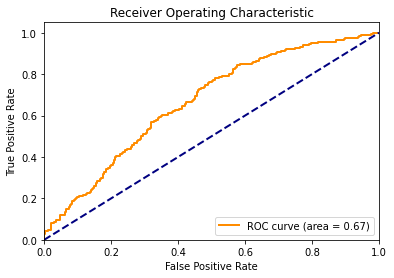

9/9 [==============================] - 1s 72ms/step - loss: 0.6917 - accuracy: 0.6143
Validation Loss: 0.6916572451591492
Validation Accuracy: 0.6142857074737549
Test Loss: 0.7159059391111134
Inference Time (seconds): 1.5231513977050781
Test Accuracy: 0.63
Confusion Matrix:
 [[148 154]
 [ 68 230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.49      0.57       302
           1       0.60      0.77      0.67       298

    accuracy                           0.63       600
   macro avg       0.64      0.63      0.62       600
weighted avg       0.64      0.63      0.62       600

ROC AUC Score: 0.6653851282279212
Metrics saved successfully


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# CNN+Dropout+Dense

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 17s 487ms/step - loss: 0.9308 - accuracy: 0.5125 - val_loss: 0.6895 - val_accuracy: 0.4786
Epoch 2/50
35/35 [==============================] - 17s 488ms/step - loss: 0.6896 - accuracy: 0.5339 - val_loss: 0.6806 - val_accuracy: 0.6107
Epoch 3/50
35/35 [==============================] - 17s 492ms/step - loss: 0.6813 - accuracy: 0.5446 - val_loss: 0.6762 - val_accuracy: 0.5964
Epoch 4/50
35/35 [==============================] - 17s 491ms/step - loss: 0.6781 - accuracy: 0.5536 - val_loss: 0.6803 - val_accuracy: 0.5821
Epoch 5/50
35/35 [==============================] - 18s 501ms/step - loss: 0.6744 - accuracy: 0.5661 - val_loss: 0.6711 - val_accuracy: 0.6214
Epoch 6/50
35/35 [==============================] - 17s 501ms/step - loss: 0.6674 - accuracy: 0.5661 - val_loss: 0.6755 - val_accuracy: 0.5893
Epoch 7/50
35/35 [==============================] - 17s 498ms/step - loss: 0.6656 - accuracy: 0.5786 - val_loss: 0.6691 - val_accuracy: 0.6071

19/19 [==============================] - 2s 77ms/step


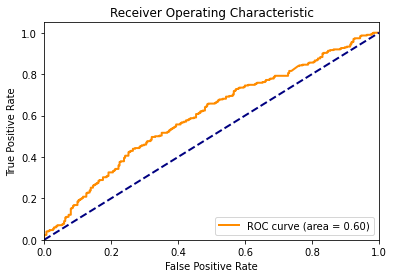

9/9 [==============================] - 1s 75ms/step - loss: 0.6335 - accuracy: 0.6393
Validation Loss: 0.6334848999977112
Validation Accuracy: 0.6392857432365417
Test Loss: 0.7463989798512669
Inference Time (seconds): 1.635707139968872
Test Accuracy: 0.5816666666666667
Confusion Matrix:
 [[207  95]
 [156 142]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.69      0.62       302
           1       0.60      0.48      0.53       298

    accuracy                           0.58       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.58      0.58      0.58       600

ROC AUC Score: 0.602015645139784
Metrics saved successfully


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 17s 497ms/step - loss: 0.5950 - accuracy: 0.6429 - val_loss: 0.6546 - val_accuracy: 0.6071
Epoch 2/100
35/35 [==============================] - 17s 493ms/step - loss: 0.5665 - accuracy: 0.6634 - val_loss: 0.6571 - val_accuracy: 0.6357
Epoch 3/100
35/35 [==============================] - 17s 496ms/step - loss: 0.5520 - accuracy: 0.6973 - val_loss: 0.6502 - val_accuracy: 0.6571
Epoch 4/100
35/35 [==============================] - 17s 496ms/step - loss: 0.5433 - accuracy: 0.6839 - val_loss: 0.6699 - val_accuracy: 0.6286
Epoch 5/100
35/35 [==============================] - 17s 496ms/step - loss: 0.5322 - accuracy: 0.6991 - val_loss: 0.6745 - val_accuracy: 0.6357
Epoch 6/100
35/35 [==============================] - 17s 492ms/step - loss: 0.5030 - accuracy: 0.7321 - val_loss: 0.7240 - val_accuracy: 0.6000
Epoch 7/100
35/35 [==============================] - 17s 494ms/step - loss: 0.4226 - accuracy: 0.7777 - val_loss: 0.7087 - val_accuracy:

19/19 [==============================] - 2s 77ms/step


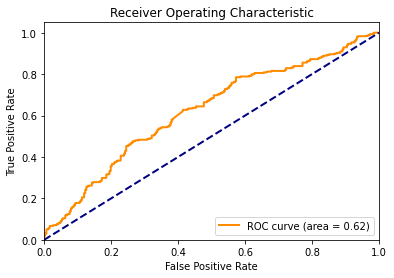

9/9 [==============================] - 1s 77ms/step - loss: 0.6502 - accuracy: 0.6571
Validation Loss: 0.6502169966697693
Validation Accuracy: 0.6571428775787354
Test Loss: 0.7835363410892677
Inference Time (seconds): 1.6199140548706055
Test Accuracy: 0.5816666666666667
Confusion Matrix:
 [[233  69]
 [182 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.77      0.65       302
           1       0.63      0.39      0.48       298

    accuracy                           0.58       600
   macro avg       0.59      0.58      0.57       600
weighted avg       0.59      0.58      0.57       600

ROC AUC Score: 0.6227110093781946
Metrics saved successfully


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 17s 496ms/step - loss: 0.5099 - accuracy: 0.7241 - val_loss: 0.6894 - val_accuracy: 0.6179
Epoch 2/150
35/35 [==============================] - 17s 493ms/step - loss: 0.4807 - accuracy: 0.7455 - val_loss: 0.6894 - val_accuracy: 0.6607
Epoch 3/150
35/35 [==============================] - 17s 494ms/step - loss: 0.4475 - accuracy: 0.7696 - val_loss: 0.7115 - val_accuracy: 0.6536
Epoch 4/150
35/35 [==============================] - 17s 495ms/step - loss: 0.3922 - accuracy: 0.8223 - val_loss: 0.7612 - val_accuracy: 0.6571
Epoch 5/150
35/35 [==============================] - 17s 493ms/step - loss: 0.3641 - accuracy: 0.8277 - val_loss: 0.7974 - val_accuracy: 0.6857
Epoch 6/150
35/35 [==============================] - 17s 495ms/step - loss: 0.3172 - accuracy: 0.8509 - val_loss: 0.7466 - val_accuracy: 0.6679
Epoch 7/150
35/35 [==============================] - 17s 497ms/step - loss: 0.2632 - accuracy: 0.8866 - val_loss: 0.9455 - val_accuracy:

19/19 [==============================] - 2s 77ms/step


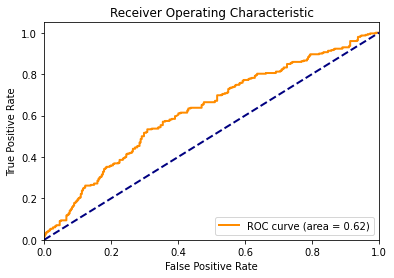

9/9 [==============================] - 1s 77ms/step - loss: 0.6894 - accuracy: 0.6607
Validation Loss: 0.6893767714500427
Validation Accuracy: 0.6607142686843872
Test Loss: 0.832451322093242
Inference Time (seconds): 1.616062879562378
Test Accuracy: 0.6083333333333333
Confusion Matrix:
 [[210  92]
 [143 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.70      0.64       302
           1       0.63      0.52      0.57       298

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.61      0.61      0.61       600

ROC AUC Score: 0.6243944175296681
Metrics saved successfully


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 17s 496ms/step - loss: 0.4359 - accuracy: 0.7795 - val_loss: 0.6623 - val_accuracy: 0.6821
Epoch 2/200
35/35 [==============================] - 17s 494ms/step - loss: 0.3942 - accuracy: 0.8098 - val_loss: 0.7656 - val_accuracy: 0.6536
Epoch 3/200
35/35 [==============================] - 17s 492ms/step - loss: 0.3594 - accuracy: 0.8188 - val_loss: 0.7490 - val_accuracy: 0.6250
Epoch 4/200
35/35 [==============================] - 17s 494ms/step - loss: 0.3421 - accuracy: 0.8438 - val_loss: 0.8877 - val_accuracy: 0.6214
Epoch 5/200
35/35 [==============================] - 17s 495ms/step - loss: 0.2980 - accuracy: 0.8687 - val_loss: 0.9249 - val_accuracy: 0.6286
Epoch 6/200
35/35 [==============================] - 17s 495ms/step - loss: 0.2523 - accuracy: 0.8857 - val_loss: 0.9471 - val_accuracy: 0.6679
Training Time: 103.86070251464844 seconds


19/19 [==============================] - 2s 78ms/step


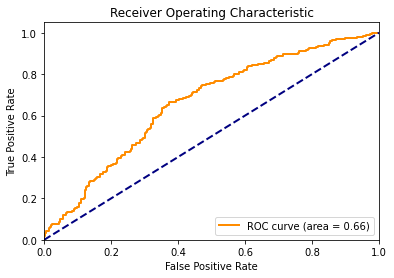

9/9 [==============================] - 1s 75ms/step - loss: 0.6623 - accuracy: 0.6821
Validation Loss: 0.6622854471206665
Validation Accuracy: 0.6821428537368774
Test Loss: 0.7804296500417289
Inference Time (seconds): 1.6276342868804932
Test Accuracy: 0.6316666666666667
Confusion Matrix:
 [[197 105]
 [116 182]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64       302
           1       0.63      0.61      0.62       298

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.63      0.63      0.63       600

ROC AUC Score: 0.6605515800702254
Metrics saved successfully


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GlobbalAveragePooling+Dense

In [29]:
from tensorflow.keras.layers import GlobalAveragePooling2D

#Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 9s 245ms/step - loss: 0.6939 - accuracy: 0.4884 - val_loss: 0.6920 - val_accuracy: 0.5250
Epoch 2/50
35/35 [==============================] - 9s 244ms/step - loss: 0.6933 - accuracy: 0.5188 - val_loss: 0.7044 - val_accuracy: 0.4786
Epoch 3/50
35/35 [==============================] - 9s 249ms/step - loss: 0.6943 - accuracy: 0.5098 - val_loss: 0.6903 - val_accuracy: 0.5929
Epoch 4/50
35/35 [==============================] - 9s 255ms/step - loss: 0.6909 - accuracy: 0.5161 - val_loss: 0.6882 - val_accuracy: 0.5679
Epoch 5/50
35/35 [==============================] - 9s 256ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6884 - val_accuracy: 0.5893
Epoch 6/50
35/35 [==============================] - 9s 256ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6864 - val_accuracy: 0.5821
Epoch 7/50
35/35 [==============================] - 8s 242ms/step - loss: 0.6908 - accuracy: 0.5312 - val_loss: 0.6856 - val_accuracy: 0.5893
Epoch 

19/19 [==============================] - 1s 69ms/step


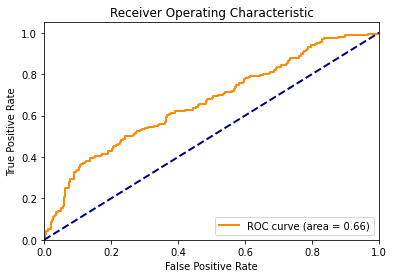

9/9 [==============================] - 1s 68ms/step - loss: 0.6229 - accuracy: 0.6214
Validation Loss: 0.6228755116462708
Validation Accuracy: 0.6214285492897034
Test Loss: 0.6615621577143249
Inference Time (seconds): 1.4765572547912598
Test Accuracy: 0.5916666666666667
Confusion Matrix:
 [[153 149]
 [ 96 202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.51      0.56       302
           1       0.58      0.68      0.62       298

    accuracy                           0.59       600
   macro avg       0.59      0.59      0.59       600
weighted avg       0.60      0.59      0.59       600

ROC AUC Score: 0.6634294857549224
Metrics saved successfully


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 9s 263ms/step - loss: 0.6370 - accuracy: 0.6179 - val_loss: 0.6142 - val_accuracy: 0.6429
Epoch 2/100
35/35 [==============================] - 9s 262ms/step - loss: 0.6456 - accuracy: 0.6170 - val_loss: 0.6310 - val_accuracy: 0.6464
Epoch 3/100
35/35 [==============================] - 9s 262ms/step - loss: 0.6425 - accuracy: 0.6054 - val_loss: 0.6135 - val_accuracy: 0.6357
Epoch 4/100
35/35 [==============================] - 9s 263ms/step - loss: 0.6326 - accuracy: 0.6196 - val_loss: 0.6144 - val_accuracy: 0.6750
Epoch 5/100
35/35 [==============================] - 9s 264ms/step - loss: 0.6339 - accuracy: 0.6027 - val_loss: 0.6216 - val_accuracy: 0.6250
Epoch 6/100
35/35 [==============================] - 9s 263ms/step - loss: 0.6245 - accuracy: 0.6375 - val_loss: 0.6091 - val_accuracy: 0.6679
Epoch 7/100
35/35 [==============================] - 9s 262ms/step - loss: 0.6249 - accuracy: 0.6348 - val_loss: 0.5962 - val_accuracy: 0.6571

19/19 [==============================] - 1s 70ms/step


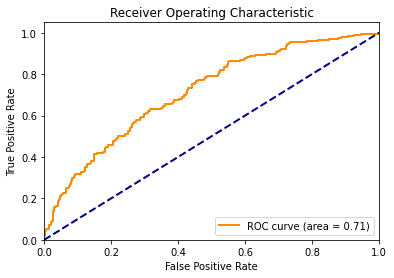

9/9 [==============================] - 1s 67ms/step - loss: 0.5586 - accuracy: 0.7214
Validation Loss: 0.5586416721343994
Validation Accuracy: 0.7214285731315613
Test Loss: 0.6376396547493236
Inference Time (seconds): 1.4629082679748535
Test Accuracy: 0.65
Confusion Matrix:
 [[212  90]
 [120 178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67       302
           1       0.66      0.60      0.63       298

    accuracy                           0.65       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.65      0.65      0.65       600

ROC AUC Score: 0.7133761500511134
Metrics saved successfully


In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [34]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 9s 263ms/step - loss: 0.5864 - accuracy: 0.6750 - val_loss: 0.5905 - val_accuracy: 0.6750
Epoch 2/150
35/35 [==============================] - 9s 261ms/step - loss: 0.5843 - accuracy: 0.6705 - val_loss: 0.5733 - val_accuracy: 0.6750
Epoch 3/150
35/35 [==============================] - 9s 262ms/step - loss: 0.5797 - accuracy: 0.6786 - val_loss: 0.5720 - val_accuracy: 0.6893
Epoch 4/150
35/35 [==============================] - 9s 263ms/step - loss: 0.5945 - accuracy: 0.6670 - val_loss: 0.5697 - val_accuracy: 0.6857
Epoch 5/150
35/35 [==============================] - 9s 260ms/step - loss: 0.5861 - accuracy: 0.6812 - val_loss: 0.5604 - val_accuracy: 0.6964
Epoch 6/150
35/35 [==============================] - 9s 264ms/step - loss: 0.5845 - accuracy: 0.6821 - val_loss: 0.6134 - val_accuracy: 0.6893
Epoch 7/150
35/35 [==============================] - 9s 261ms/step - loss: 0.5858 - accuracy: 0.6759 - val_loss: 0.6400 - val_accuracy: 0.6679

19/19 [==============================] - 1s 70ms/step


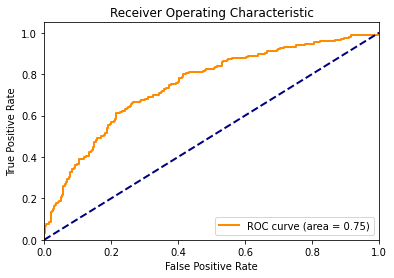

9/9 [==============================] - 1s 67ms/step - loss: 0.5440 - accuracy: 0.7357
Validation Loss: 0.5439860820770264
Validation Accuracy: 0.7357142567634583
Test Loss: 0.622411317079239
Inference Time (seconds): 1.4785513877868652
Test Accuracy: 0.6933333333333334
Confusion Matrix:
 [[228  74]
 [110 188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71       302
           1       0.72      0.63      0.67       298

    accuracy                           0.69       600
   macro avg       0.70      0.69      0.69       600
weighted avg       0.70      0.69      0.69       600

ROC AUC Score: 0.7474665540690696
Metrics saved successfully


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [36]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 9s 263ms/step - loss: 0.5438 - accuracy: 0.7321 - val_loss: 0.5454 - val_accuracy: 0.7321
Epoch 2/200
35/35 [==============================] - 9s 263ms/step - loss: 0.5639 - accuracy: 0.7000 - val_loss: 0.5443 - val_accuracy: 0.7464
Epoch 3/200
35/35 [==============================] - 9s 266ms/step - loss: 0.5329 - accuracy: 0.7304 - val_loss: 0.5673 - val_accuracy: 0.6714
Epoch 4/200
35/35 [==============================] - 9s 260ms/step - loss: 0.5368 - accuracy: 0.7232 - val_loss: 0.5481 - val_accuracy: 0.7179
Epoch 5/200
35/35 [==============================] - 9s 258ms/step - loss: 0.5415 - accuracy: 0.7143 - val_loss: 0.5476 - val_accuracy: 0.7250
Epoch 6/200
35/35 [==============================] - 9s 256ms/step - loss: 0.5276 - accuracy: 0.7339 - val_loss: 0.5537 - val_accuracy: 0.7214
Epoch 7/200
35/35 [==============================] - 9s 256ms/step - loss: 0.5370 - accuracy: 0.7196 - val_loss: 0.6173 - val_accuracy: 0.6393

19/19 [==============================] - 1s 68ms/step


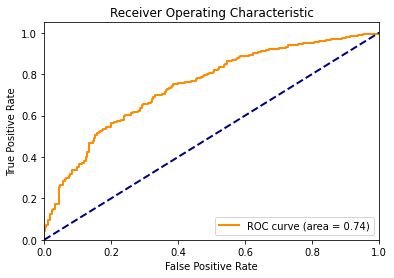

9/9 [==============================] - 1s 66ms/step - loss: 0.5443 - accuracy: 0.7464
Validation Loss: 0.5442803502082825
Validation Accuracy: 0.7464285492897034
Test Loss: 0.6189978056452404
Inference Time (seconds): 1.4292824268341064
Test Accuracy: 0.6733333333333333
Confusion Matrix:
 [[215  87]
 [109 189]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.69       302
           1       0.68      0.63      0.66       298

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600

ROC AUC Score: 0.7428774612204987
Metrics saved successfully


In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Conv2D+GlobalAveragePooling+Dropout+Dense

In [40]:
# Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 global_average_pooling2d_2  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 29s 829ms/step - loss: 0.6949 - accuracy: 0.4786 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 2/50
35/35 [==============================] - 29s 832ms/step - loss: 0.6946 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.4786
Epoch 3/50
35/35 [==============================] - 30s 846ms/step - loss: 0.6934 - accuracy: 0.5045 - val_loss: 0.6949 - val_accuracy: 0.4786
Epoch 4/50
35/35 [==============================] - 31s 881ms/step - loss: 0.6936 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.4786
Epoch 5/50
35/35 [==============================] - 31s 885ms/step - loss: 0.6930 - accuracy: 0.4982 - val_loss: 0.6913 - val_accuracy: 0.4786
Epoch 6/50
35/35 [==============================] - 31s 885ms/step - loss: 0.6923 - accuracy: 0.5241 - val_loss: 0.6893 - val_accuracy: 0.5786
Epoch 7/50
35/35 [==============================] - 32s 904ms/step - loss: 0.6916 - accuracy: 0.5259 - val_loss: 0.6877 - val_accuracy: 0.5679

19/19 [==============================] - 3s 179ms/step


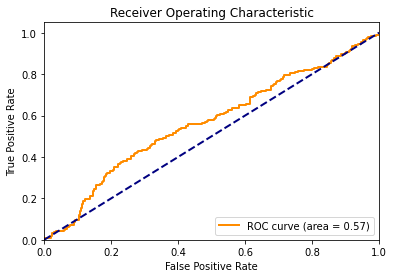

9/9 [==============================] - 2s 177ms/step - loss: 0.6813 - accuracy: 0.5893
Validation Loss: 0.6812893748283386
Validation Accuracy: 0.5892857313156128
Test Loss: 0.6869892373931734
Inference Time (seconds): 3.5732979774475098
Test Accuracy: 0.5516666666666666
Confusion Matrix:
 [[164 138]
 [131 167]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.54      0.55       302
           1       0.55      0.56      0.55       298

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.55      0.55      0.55       600

ROC AUC Score: 0.5655918040801814
Metrics saved successfully


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [43]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 31s 897ms/step - loss: 0.6872 - accuracy: 0.5446 - val_loss: 0.6825 - val_accuracy: 0.5857
Epoch 2/100
35/35 [==============================] - 30s 866ms/step - loss: 0.6880 - accuracy: 0.5393 - val_loss: 0.6808 - val_accuracy: 0.5857
Epoch 3/100
35/35 [==============================] - 31s 875ms/step - loss: 0.6889 - accuracy: 0.5446 - val_loss: 0.6810 - val_accuracy: 0.5929
Epoch 4/100
35/35 [==============================] - 30s 864ms/step - loss: 0.6847 - accuracy: 0.5500 - val_loss: 0.6781 - val_accuracy: 0.5929
Epoch 5/100
35/35 [==============================] - 30s 864ms/step - loss: 0.6838 - accuracy: 0.5518 - val_loss: 0.6768 - val_accuracy: 0.6107
Epoch 6/100
35/35 [==============================] - 30s 868ms/step - loss: 0.6881 - accuracy: 0.5437 - val_loss: 0.6799 - val_accuracy: 0.6000
Epoch 7/100
35/35 [==============================] - 31s 894ms/step - loss: 0.6864 - accuracy: 0.5482 - val_loss: 0.6772 - val_accuracy:

19/19 [==============================] - 3s 179ms/step


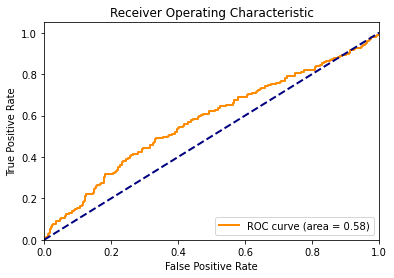

9/9 [==============================] - 2s 177ms/step - loss: 0.6768 - accuracy: 0.6107
Validation Loss: 0.6767913699150085
Validation Accuracy: 0.6107142567634583
Test Loss: 0.6836386224925864
Inference Time (seconds): 3.538501262664795
Test Accuracy: 0.5683333333333334
Confusion Matrix:
 [[215  87]
 [172 126]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.62       302
           1       0.59      0.42      0.49       298

    accuracy                           0.57       600
   macro avg       0.57      0.57      0.56       600
weighted avg       0.57      0.57      0.56       600

ROC AUC Score: 0.5772589892884128
Metrics saved successfully


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [45]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 31s 876ms/step - loss: 0.6860 - accuracy: 0.5527 - val_loss: 0.6931 - val_accuracy: 0.4786
Epoch 2/150
35/35 [==============================] - 31s 883ms/step - loss: 0.6896 - accuracy: 0.5339 - val_loss: 0.6828 - val_accuracy: 0.5857
Epoch 3/150
35/35 [==============================] - 31s 877ms/step - loss: 0.6861 - accuracy: 0.5464 - val_loss: 0.6761 - val_accuracy: 0.6071
Epoch 4/150
35/35 [==============================] - 31s 882ms/step - loss: 0.6865 - accuracy: 0.5437 - val_loss: 0.6751 - val_accuracy: 0.6000
Epoch 5/150
35/35 [==============================] - 31s 881ms/step - loss: 0.6806 - accuracy: 0.5607 - val_loss: 0.6654 - val_accuracy: 0.6214
Epoch 6/150
35/35 [==============================] - 32s 905ms/step - loss: 0.6801 - accuracy: 0.5580 - val_loss: 0.6684 - val_accuracy: 0.6214
Epoch 7/150
35/35 [==============================] - 31s 876ms/step - loss: 0.6834 - accuracy: 0.5518 - val_loss: 0.6711 - val_accuracy:

19/19 [==============================] - 3s 150ms/step


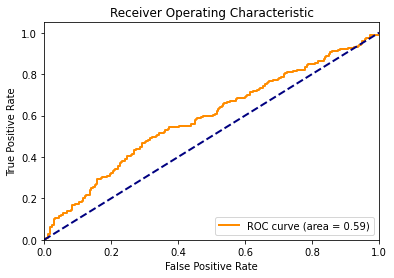

9/9 [==============================] - 1s 148ms/step - loss: 0.6630 - accuracy: 0.6214
Validation Loss: 0.66298508644104
Validation Accuracy: 0.6214285492897034
Test Loss: 0.6814712284678135
Inference Time (seconds): 3.008700132369995
Test Accuracy: 0.5583333333333333
Confusion Matrix:
 [[171 131]
 [134 164]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.57      0.56       302
           1       0.56      0.55      0.55       298

    accuracy                           0.56       600
   macro avg       0.56      0.56      0.56       600
weighted avg       0.56      0.56      0.56       600

ROC AUC Score: 0.589615094004178
Metrics saved successfully


In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 30s 857ms/step - loss: 0.6804 - accuracy: 0.5696 - val_loss: 0.6743 - val_accuracy: 0.5964
Epoch 2/200
35/35 [==============================] - 32s 921ms/step - loss: 0.6863 - accuracy: 0.5348 - val_loss: 0.6768 - val_accuracy: 0.6071
Epoch 3/200
35/35 [==============================] - 31s 882ms/step - loss: 0.6855 - accuracy: 0.5518 - val_loss: 0.6730 - val_accuracy: 0.6000
Epoch 4/200
35/35 [==============================] - 31s 875ms/step - loss: 0.6834 - accuracy: 0.5554 - val_loss: 0.6727 - val_accuracy: 0.6036
Epoch 5/200
35/35 [==============================] - 31s 888ms/step - loss: 0.6847 - accuracy: 0.5482 - val_loss: 0.6693 - val_accuracy: 0.6071
Epoch 6/200
35/35 [==============================] - 31s 890ms/step - loss: 0.6834 - accuracy: 0.5509 - val_loss: 0.6627 - val_accuracy: 0.6250
Epoch 7/200
35/35 [==============================] - 31s 886ms/step - loss: 0.6849 - accuracy: 0.5429 - val_loss: 0.6726 - val_accuracy:

19/19 [==============================] - 3s 181ms/step


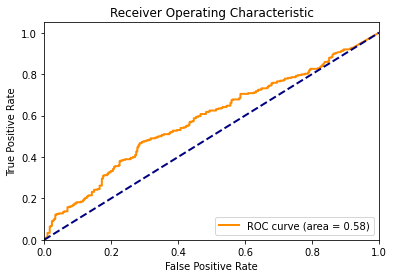

9/9 [==============================] - 2s 178ms/step - loss: 0.6627 - accuracy: 0.6250
Validation Loss: 0.6627333760261536
Validation Accuracy: 0.625
Test Loss: 0.680056910094882
Inference Time (seconds): 3.58044695854187
Test Accuracy: 0.5766666666666667
Confusion Matrix:
 [[194 108]
 [146 152]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.64      0.60       302
           1       0.58      0.51      0.54       298

    accuracy                           0.58       600
   macro avg       0.58      0.58      0.57       600
weighted avg       0.58      0.58      0.57       600

ROC AUC Score: 0.5840092893017467
Metrics saved successfully


In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+LSTM+Dense

In [54]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape,LSTM
from tensorflow.keras.models import Model


# Define the input shape
input_shape = (224, 224, 3)

# Define the CNN base model
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Define the LSTM layer
reshape = Reshape((1, -1))(flatten)
lstm = LSTM(128)(reshape)

# Define the dense layers for classification
dense1 = Dense(64, activation='relu')(lstm)
output_layer = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 186624)            0     

In [55]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 28s 785ms/step - loss: 0.7155 - accuracy: 0.4973 - val_loss: 0.6964 - val_accuracy: 0.4786
Epoch 2/50
35/35 [==============================] - 27s 779ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6867 - val_accuracy: 0.4964
Epoch 3/50
35/35 [==============================] - 27s 772ms/step - loss: 0.6902 - accuracy: 0.5420 - val_loss: 0.6948 - val_accuracy: 0.4786
Epoch 4/50
35/35 [==============================] - 27s 770ms/step - loss: 0.6861 - accuracy: 0.5437 - val_loss: 0.6764 - val_accuracy: 0.6179
Epoch 5/50
35/35 [==============================] - 27s 769ms/step - loss: 0.6835 - accuracy: 0.5420 - val_loss: 0.7069 - val_accuracy: 0.5214
Epoch 6/50
35/35 [==============================] - 27s 770ms/step - loss: 0.6981 - accuracy: 0.5054 - val_loss: 0.6923 - val_accuracy: 0.5214
Epoch 7/50
35/35 [==============================] - 27s 769ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5214

19/19 [==============================] - 2s 74ms/step


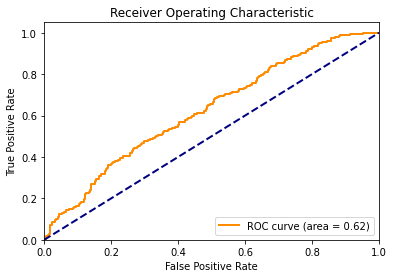

9/9 [==============================] - 1s 73ms/step - loss: 0.6764 - accuracy: 0.6179
Validation Loss: 0.6763655543327332
Validation Accuracy: 0.6178571581840515
Test Loss: 0.682176748272773
Inference Time (seconds): 1.6990156173706055
Test Accuracy: 0.58
Confusion Matrix:
 [[196 106]
 [146 152]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       302
           1       0.59      0.51      0.55       298

    accuracy                           0.58       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.58      0.58      0.58       600

ROC AUC Score: 0.6244610871594293
Metrics saved successfully


In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [57]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 27s 777ms/step - loss: 0.6934 - accuracy: 0.5339 - val_loss: 0.6924 - val_accuracy: 0.5036
Epoch 2/100
35/35 [==============================] - 27s 772ms/step - loss: 0.6995 - accuracy: 0.4848 - val_loss: 0.7206 - val_accuracy: 0.4786
Epoch 3/100
35/35 [==============================] - 27s 770ms/step - loss: 0.7026 - accuracy: 0.4911 - val_loss: 0.6933 - val_accuracy: 0.4786
Epoch 4/100
35/35 [==============================] - 27s 771ms/step - loss: 0.6966 - accuracy: 0.4839 - val_loss: 0.6936 - val_accuracy: 0.4786
Epoch 5/100
35/35 [==============================] - 27s 773ms/step - loss: 0.6955 - accuracy: 0.4696 - val_loss: 0.6958 - val_accuracy: 0.4786
Epoch 6/100
35/35 [==============================] - 27s 772ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.4786
Training Time: 162.38085865974426 seconds


19/19 [==============================] - 1s 73ms/step


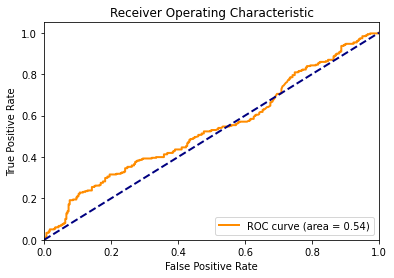

9/9 [==============================] - 1s 72ms/step - loss: 0.6924 - accuracy: 0.5036
Validation Loss: 0.6923513412475586
Validation Accuracy: 0.5035714507102966
Test Loss: 0.6922314811871736
Inference Time (seconds): 1.548982858657837
Test Accuracy: 0.51
Confusion Matrix:
 [[ 38 264]
 [ 30 268]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.13      0.21       302
           1       0.50      0.90      0.65       298

    accuracy                           0.51       600
   macro avg       0.53      0.51      0.43       600
weighted avg       0.53      0.51      0.42       600

ROC AUC Score: 0.5416018489710653
Metrics saved successfully


In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [59]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 27s 778ms/step - loss: 0.6969 - accuracy: 0.4911 - val_loss: 0.6920 - val_accuracy: 0.5214
Epoch 2/150
35/35 [==============================] - 27s 771ms/step - loss: 0.6929 - accuracy: 0.5259 - val_loss: 0.7042 - val_accuracy: 0.5214
Epoch 3/150
35/35 [==============================] - 27s 773ms/step - loss: 0.7043 - accuracy: 0.4786 - val_loss: 0.6987 - val_accuracy: 0.4786
Epoch 4/150
35/35 [==============================] - 27s 773ms/step - loss: 0.6972 - accuracy: 0.4911 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 5/150
35/35 [==============================] - 27s 770ms/step - loss: 0.6966 - accuracy: 0.5054 - val_loss: 0.6934 - val_accuracy: 0.4786
Epoch 6/150
35/35 [==============================] - 27s 776ms/step - loss: 0.6955 - accuracy: 0.4688 - val_loss: 0.6966 - val_accuracy: 0.4786
Training Time: 162.53421092033386 seconds


19/19 [==============================] - 1s 74ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


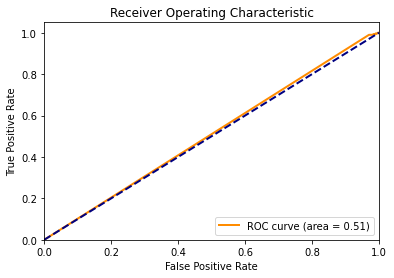

9/9 [==============================] - 1s 71ms/step - loss: 0.6920 - accuracy: 0.5214
Validation Loss: 0.6919698715209961
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6933889968593447
Inference Time (seconds): 1.5448968410491943
Test Accuracy: 0.5033333333333333
Confusion Matrix:
 [[302   0]
 [298   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

ROC AUC Score: 0.5098171029823548
Metrics saved successfully


In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [61]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 27s 776ms/step - loss: 0.6950 - accuracy: 0.4821 - val_loss: 0.6980 - val_accuracy: 0.4786
Epoch 2/200
35/35 [==============================] - 27s 774ms/step - loss: 0.6953 - accuracy: 0.4911 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 3/200
35/35 [==============================] - 27s 773ms/step - loss: 0.6941 - accuracy: 0.4839 - val_loss: 0.7009 - val_accuracy: 0.4786
Epoch 4/200
35/35 [==============================] - 27s 771ms/step - loss: 0.6943 - accuracy: 0.5071 - val_loss: 0.6935 - val_accuracy: 0.4786
Epoch 5/200
35/35 [==============================] - 27s 772ms/step - loss: 0.6945 - accuracy: 0.5089 - val_loss: 0.7069 - val_accuracy: 0.4786
Epoch 6/200
35/35 [==============================] - 27s 773ms/step - loss: 0.6960 - accuracy: 0.4714 - val_loss: 0.6923 - val_accuracy: 0.5214
Epoch 7/200
35/35 [==============================] - 27s 771ms/step - loss: 0.6981 - accuracy: 0.5107 - val_loss: 0.6934 - val_accuracy:

19/19 [==============================] - 1s 73ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


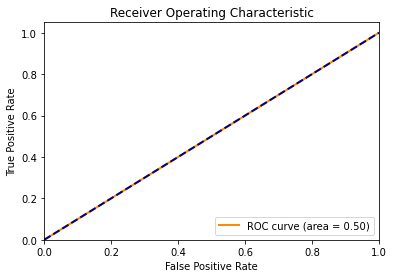

9/9 [==============================] - 1s 73ms/step - loss: 0.6923 - accuracy: 0.5214
Validation Loss: 0.6922808289527893
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6934623223303303
Inference Time (seconds): 1.5205662250518799
Test Accuracy: 0.5033333333333333
Confusion Matrix:
 [[302   0]
 [298   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

ROC AUC Score: 0.5
Metrics saved successfully


In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GRU+Dense

In [65]:
from tensorflow.keras.layers import GRU

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(256, (3, 3), activation='relu'),  # Convolutional layer with 256 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to flatten the output of the convolutional layers
    Reshape((1, -1)),  # Reshape to 3D tensor for GRU
    GRU(128),  # GRU layer with 128 units
    Dense(1, activation='sigmoid')  # Dense layer for binary classification
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()                                                               

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 26, 26, 128)      

In [66]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 13s 363ms/step - loss: 0.7215 - accuracy: 0.5125 - val_loss: 0.6809 - val_accuracy: 0.5786
Epoch 2/50
35/35 [==============================] - 13s 362ms/step - loss: 0.6858 - accuracy: 0.5304 - val_loss: 0.6742 - val_accuracy: 0.6143
Epoch 3/50
35/35 [==============================] - 13s 375ms/step - loss: 0.6753 - accuracy: 0.5571 - val_loss: 0.6758 - val_accuracy: 0.5107
Epoch 4/50
35/35 [==============================] - 13s 375ms/step - loss: 0.6854 - accuracy: 0.5429 - val_loss: 0.6761 - val_accuracy: 0.5857
Epoch 5/50
35/35 [==============================] - 13s 377ms/step - loss: 0.6723 - accuracy: 0.5625 - val_loss: 0.6603 - val_accuracy: 0.6286
Epoch 6/50
35/35 [==============================] - 13s 375ms/step - loss: 0.6662 - accuracy: 0.5813 - val_loss: 0.6657 - val_accuracy: 0.6179
Epoch 7/50
35/35 [==============================] - 13s 373ms/step - loss: 0.6620 - accuracy: 0.5652 - val_loss: 0.6557 - val_accuracy: 0.6143

19/19 [==============================] - 2s 85ms/step


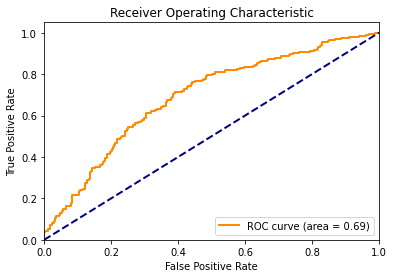

9/9 [==============================] - 1s 85ms/step - loss: 0.6189 - accuracy: 0.7000
Validation Loss: 0.618865430355072
Validation Accuracy: 0.699999988079071
Test Loss: 0.6673833758832048
Inference Time (seconds): 1.9057776927947998
Test Accuracy: 0.65
Confusion Matrix:
 [[160 142]
 [ 68 230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.53      0.60       302
           1       0.62      0.77      0.69       298

    accuracy                           0.65       600
   macro avg       0.66      0.65      0.65       600
weighted avg       0.66      0.65      0.64       600

ROC AUC Score: 0.6894528645717588
Metrics saved successfully


In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [68]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 13s 376ms/step - loss: 0.5697 - accuracy: 0.6786 - val_loss: 0.7121 - val_accuracy: 0.5857
Epoch 2/100
35/35 [==============================] - 13s 375ms/step - loss: 0.5503 - accuracy: 0.7063 - val_loss: 0.6991 - val_accuracy: 0.6536
Epoch 3/100
35/35 [==============================] - 13s 376ms/step - loss: 0.5360 - accuracy: 0.7063 - val_loss: 0.7061 - val_accuracy: 0.6250
Epoch 4/100
35/35 [==============================] - 13s 374ms/step - loss: 0.5121 - accuracy: 0.7437 - val_loss: 0.6373 - val_accuracy: 0.7143
Epoch 5/100
35/35 [==============================] - 13s 372ms/step - loss: 0.5173 - accuracy: 0.7384 - val_loss: 0.7484 - val_accuracy: 0.5929
Epoch 6/100
35/35 [==============================] - 13s 372ms/step - loss: 0.5305 - accuracy: 0.7161 - val_loss: 0.7462 - val_accuracy: 0.5500
Epoch 7/100
35/35 [==============================] - 13s 372ms/step - loss: 0.4956 - accuracy: 0.7563 - val_loss: 0.7554 - val_accuracy:

19/19 [==============================] - 2s 85ms/step


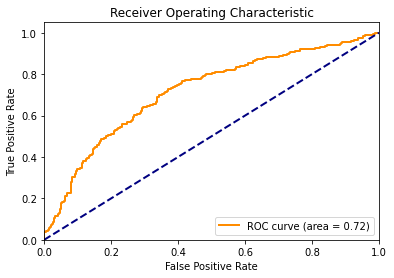

9/9 [==============================] - 1s 85ms/step - loss: 0.6373 - accuracy: 0.7143
Validation Loss: 0.6373236775398254
Validation Accuracy: 0.7142857313156128
Test Loss: 0.701650424916384
Inference Time (seconds): 1.7723217010498047
Test Accuracy: 0.6766666666666666
Confusion Matrix:
 [[193 109]
 [ 85 213]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.67       302
           1       0.66      0.71      0.69       298

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600

ROC AUC Score: 0.7152651228943508
Metrics saved successfully


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [70]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 13s 383ms/step - loss: 0.4641 - accuracy: 0.7786 - val_loss: 0.6615 - val_accuracy: 0.7357
Epoch 2/150
35/35 [==============================] - 13s 374ms/step - loss: 0.4524 - accuracy: 0.7777 - val_loss: 0.7990 - val_accuracy: 0.6250
Epoch 3/150
35/35 [==============================] - 13s 374ms/step - loss: 0.4405 - accuracy: 0.7866 - val_loss: 0.7560 - val_accuracy: 0.6714
Epoch 4/150
35/35 [==============================] - 13s 373ms/step - loss: 0.4226 - accuracy: 0.7786 - val_loss: 0.7366 - val_accuracy: 0.7107
Epoch 5/150
35/35 [==============================] - 13s 372ms/step - loss: 0.3911 - accuracy: 0.8188 - val_loss: 0.7972 - val_accuracy: 0.7036
Epoch 6/150
35/35 [==============================] - 13s 374ms/step - loss: 0.3586 - accuracy: 0.8411 - val_loss: 0.6772 - val_accuracy: 0.7321
Training Time: 78.89354228973389 seconds


19/19 [==============================] - 2s 85ms/step


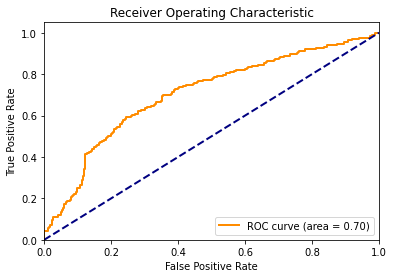

9/9 [==============================] - 1s 84ms/step - loss: 0.6615 - accuracy: 0.7357
Validation Loss: 0.6615013480186462
Validation Accuracy: 0.7357142567634583
Test Loss: 0.8149426588013676
Inference Time (seconds): 1.7609708309173584
Test Accuracy: 0.67
Confusion Matrix:
 [[228  74]
 [124 174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70       302
           1       0.70      0.58      0.64       298

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600

ROC AUC Score: 0.7040201786746076
Metrics saved successfully


In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 13s 378ms/step - loss: 0.4366 - accuracy: 0.7875 - val_loss: 0.6914 - val_accuracy: 0.7250
Epoch 2/200
35/35 [==============================] - 13s 373ms/step - loss: 0.4175 - accuracy: 0.8036 - val_loss: 0.8006 - val_accuracy: 0.7036
Epoch 3/200
35/35 [==============================] - 13s 375ms/step - loss: 0.4029 - accuracy: 0.8152 - val_loss: 0.7129 - val_accuracy: 0.7143
Epoch 4/200
35/35 [==============================] - 13s 372ms/step - loss: 0.3820 - accuracy: 0.8054 - val_loss: 0.7647 - val_accuracy: 0.7143
Epoch 5/200
35/35 [==============================] - 13s 373ms/step - loss: 0.3757 - accuracy: 0.8286 - val_loss: 0.7485 - val_accuracy: 0.7536
Epoch 6/200
35/35 [==============================] - 13s 374ms/step - loss: 0.3151 - accuracy: 0.8652 - val_loss: 0.8234 - val_accuracy: 0.7321
Training Time: 78.67983865737915 seconds


19/19 [==============================] - 2s 85ms/step


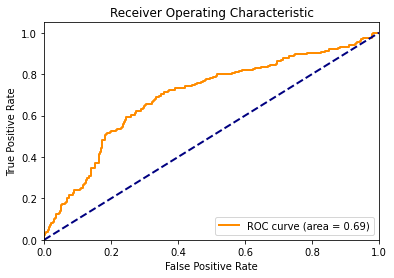

9/9 [==============================] - 1s 84ms/step - loss: 0.6914 - accuracy: 0.7250
Validation Loss: 0.6914297938346863
Validation Accuracy: 0.7250000238418579
Test Loss: 0.8268318574754271
Inference Time (seconds): 1.7672650814056396
Test Accuracy: 0.6483333333333333
Confusion Matrix:
 [[163 139]
 [ 72 226]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.54      0.61       302
           1       0.62      0.76      0.68       298

    accuracy                           0.65       600
   macro avg       0.66      0.65      0.64       600
weighted avg       0.66      0.65      0.64       600

ROC AUC Score: 0.6948197697675452
Metrics saved successfully


In [73]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Attention Mechanism+Dense

In [76]:
from tensorflow.keras.layers import Multiply

#Define the custom CNN architecture with attention mechanism
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
attention_probs = Dense(np.prod(x.shape[1:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
x = Dense(1, activation='sigmoid')(attention_mul)

# Create the model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 222, 222, 32)         896       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_39 (MaxPooli  (None, 111, 111, 32)         0         ['conv2d_43[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_44 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_39[0][0]

In [77]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 13s 371ms/step - loss: 0.6934 - accuracy: 0.4875 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 2/50
35/35 [==============================] - 13s 367ms/step - loss: 0.6931 - accuracy: 0.5152 - val_loss: 0.6939 - val_accuracy: 0.4786
Epoch 3/50
35/35 [==============================] - 13s 365ms/step - loss: 0.6933 - accuracy: 0.5071 - val_loss: 0.6932 - val_accuracy: 0.4786
Epoch 4/50
35/35 [==============================] - 13s 375ms/step - loss: 0.6917 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4786
Epoch 5/50
35/35 [==============================] - 13s 373ms/step - loss: 0.6933 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.4821
Epoch 6/50
35/35 [==============================] - 13s 374ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6928 - val_accuracy: 0.4929
Epoch 7/50
35/35 [==============================] - 13s 373ms/step - loss: 0.6918 - accuracy: 0.5170 - val_loss: 0.6848 - val_accuracy: 0.4786

19/19 [==============================] - 1s 74ms/step


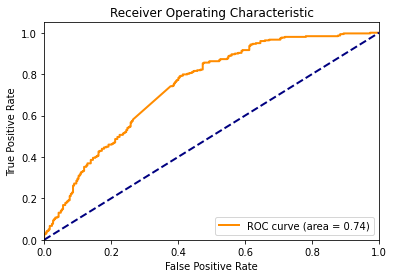

9/9 [==============================] - 1s 72ms/step - loss: 0.5281 - accuracy: 0.7250
Validation Loss: 0.5281250476837158
Validation Accuracy: 0.7250000238418579
Test Loss: 0.6072405669301062
Inference Time (seconds): 1.581110954284668
Test Accuracy: 0.6433333333333333
Confusion Matrix:
 [[227  75]
 [139 159]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68       302
           1       0.68      0.53      0.60       298

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.65      0.64      0.64       600

ROC AUC Score: 0.7399884439308414
Metrics saved successfully


In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [79]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 13s 376ms/step - loss: 0.5057 - accuracy: 0.7464 - val_loss: 0.5378 - val_accuracy: 0.7250
Epoch 2/100
35/35 [==============================] - 13s 374ms/step - loss: 0.4612 - accuracy: 0.7670 - val_loss: 0.5251 - val_accuracy: 0.7393
Epoch 3/100
35/35 [==============================] - 13s 372ms/step - loss: 0.4673 - accuracy: 0.7634 - val_loss: 0.5868 - val_accuracy: 0.7143
Epoch 4/100
35/35 [==============================] - 13s 373ms/step - loss: 0.4754 - accuracy: 0.7661 - val_loss: 0.5173 - val_accuracy: 0.7214
Epoch 5/100
35/35 [==============================] - 13s 372ms/step - loss: 0.4681 - accuracy: 0.7545 - val_loss: 0.5547 - val_accuracy: 0.7214
Epoch 6/100
35/35 [==============================] - 13s 374ms/step - loss: 0.4435 - accuracy: 0.7696 - val_loss: 0.5640 - val_accuracy: 0.7179
Epoch 7/100
35/35 [==============================] - 13s 373ms/step - loss: 0.4538 - accuracy: 0.7634 - val_loss: 0.5845 - val_accuracy:

19/19 [==============================] - 1s 68ms/step


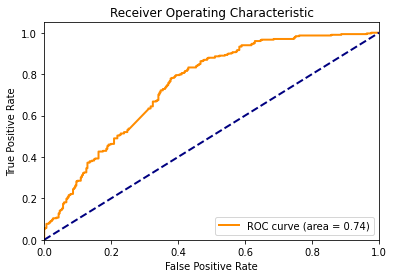

9/9 [==============================] - 1s 66ms/step - loss: 0.5173 - accuracy: 0.7214
Validation Loss: 0.5173201560974121
Validation Accuracy: 0.7214285731315613
Test Loss: 0.6391742434399742
Inference Time (seconds): 1.4486844539642334
Test Accuracy: 0.64
Confusion Matrix:
 [[229  73]
 [143 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68       302
           1       0.68      0.52      0.59       298

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.63       600
weighted avg       0.65      0.64      0.63       600

ROC AUC Score: 0.7442219654206854
Metrics saved successfully


In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [82]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 13s 366ms/step - loss: 0.4400 - accuracy: 0.7777 - val_loss: 0.5192 - val_accuracy: 0.7607
Epoch 2/150
35/35 [==============================] - 13s 367ms/step - loss: 0.4274 - accuracy: 0.7973 - val_loss: 0.5382 - val_accuracy: 0.7393
Epoch 3/150
35/35 [==============================] - 13s 367ms/step - loss: 0.3997 - accuracy: 0.8027 - val_loss: 0.5352 - val_accuracy: 0.7500
Epoch 4/150
35/35 [==============================] - 13s 365ms/step - loss: 0.4049 - accuracy: 0.8036 - val_loss: 0.5209 - val_accuracy: 0.7607
Epoch 5/150
35/35 [==============================] - 13s 367ms/step - loss: 0.4368 - accuracy: 0.7759 - val_loss: 0.5931 - val_accuracy: 0.7286
Epoch 6/150
35/35 [==============================] - 13s 368ms/step - loss: 0.4271 - accuracy: 0.7902 - val_loss: 0.5544 - val_accuracy: 0.7214
Training Time: 77.11764287948608 seconds


19/19 [==============================] - 1s 72ms/step


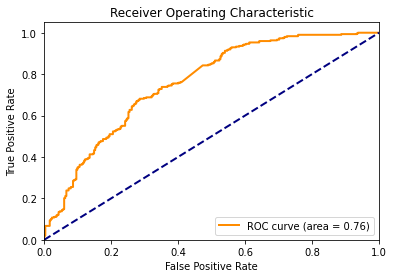

9/9 [==============================] - 1s 71ms/step - loss: 0.5192 - accuracy: 0.7607
Validation Loss: 0.5192484259605408
Validation Accuracy: 0.7607142925262451
Test Loss: 0.6434810271571121
Inference Time (seconds): 1.5172202587127686
Test Accuracy: 0.6783333333333333
Confusion Matrix:
 [[182 120]
 [ 73 225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.60      0.65       302
           1       0.65      0.76      0.70       298

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600

ROC AUC Score: 0.7565225121116493
Metrics saved successfully


In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [84]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 13s 372ms/step - loss: 0.4323 - accuracy: 0.7768 - val_loss: 0.6521 - val_accuracy: 0.6964
Epoch 2/200
35/35 [==============================] - 13s 374ms/step - loss: 0.4536 - accuracy: 0.7670 - val_loss: 0.5797 - val_accuracy: 0.7107
Epoch 3/200
35/35 [==============================] - 13s 373ms/step - loss: 0.4132 - accuracy: 0.7902 - val_loss: 0.5657 - val_accuracy: 0.7321
Epoch 4/200
35/35 [==============================] - 13s 374ms/step - loss: 0.4395 - accuracy: 0.7741 - val_loss: 0.5965 - val_accuracy: 0.6679
Epoch 5/200
35/35 [==============================] - 13s 377ms/step - loss: 0.4709 - accuracy: 0.7089 - val_loss: 0.5673 - val_accuracy: 0.6643
Epoch 6/200
35/35 [==============================] - 13s 373ms/step - loss: 0.4446 - accuracy: 0.7688 - val_loss: 0.5189 - val_accuracy: 0.7286
Epoch 7/200
35/35 [==============================] - 13s 374ms/step - loss: 0.4154 - accuracy: 0.7911 - val_loss: 0.5112 - val_accuracy:

19/19 [==============================] - 1s 74ms/step


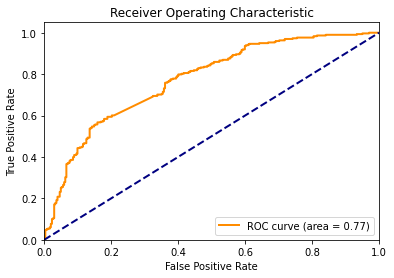

9/9 [==============================] - 1s 72ms/step - loss: 0.5112 - accuracy: 0.7571
Validation Loss: 0.5111604928970337
Validation Accuracy: 0.7571428418159485
Test Loss: 0.6297471372323272
Inference Time (seconds): 1.5544970035552979
Test Accuracy: 0.7
Confusion Matrix:
 [[246  56]
 [124 174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.81      0.73       302
           1       0.76      0.58      0.66       298

    accuracy                           0.70       600
   macro avg       0.71      0.70      0.70       600
weighted avg       0.71      0.70      0.70       600

ROC AUC Score: 0.7727176763411707
Metrics saved successfully


In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Capsule Network+Dense

In [87]:
from tensorflow.keras.layers import Layer

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j
# Define your custom CNN architecture
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((-1, 128))(x)  # Reshape to 3D tensor for Capsule Network
capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
capsule = Flatten()(capsule)  # Flatten the output
output = Dense(1, activation='sigmoid')(capsule)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_46 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 52, 52, 128)       7385

In [88]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 11s 314ms/step - loss: 0.6927 - accuracy: 0.5170 - val_loss: 0.6865 - val_accuracy: 0.5357
Epoch 2/50
35/35 [==============================] - 11s 305ms/step - loss: 0.6923 - accuracy: 0.5098 - val_loss: 0.6893 - val_accuracy: 0.5179
Epoch 3/50
35/35 [==============================] - 11s 312ms/step - loss: 0.6831 - accuracy: 0.5518 - val_loss: 0.6847 - val_accuracy: 0.5179
Epoch 4/50
35/35 [==============================] - 11s 316ms/step - loss: 0.6870 - accuracy: 0.5348 - val_loss: 0.6760 - val_accuracy: 0.6357
Epoch 5/50
35/35 [==============================] - 11s 316ms/step - loss: 0.6774 - accuracy: 0.5464 - val_loss: 0.6746 - val_accuracy: 0.5143
Epoch 6/50
35/35 [==============================] - 11s 314ms/step - loss: 0.6710 - accuracy: 0.5777 - val_loss: 0.6665 - val_accuracy: 0.5464
Epoch 7/50
35/35 [==============================] - 11s 318ms/step - loss: 0.6631 - accuracy: 0.5875 - val_loss: 0.6379 - val_accuracy: 0.6536

19/19 [==============================] - 1s 68ms/step


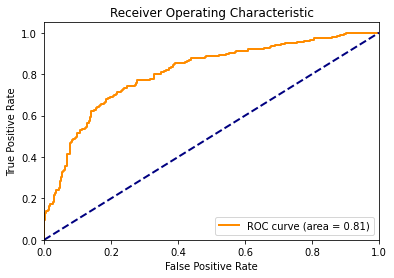

9/9 [==============================] - 1s 65ms/step - loss: 0.4792 - accuracy: 0.8071
Validation Loss: 0.47920292615890503
Validation Accuracy: 0.8071428537368774
Test Loss: 0.5423799753110662
Inference Time (seconds): 1.4931435585021973
Test Accuracy: 0.7366666666666667
Confusion Matrix:
 [[219  83]
 [ 75 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       302
           1       0.73      0.75      0.74       298

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600

ROC AUC Score: 0.8083248144361972
Metrics saved successfully


In [90]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [91]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 11s 304ms/step - loss: 0.4512 - accuracy: 0.7964 - val_loss: 0.5098 - val_accuracy: 0.7500
Epoch 2/100
35/35 [==============================] - 11s 305ms/step - loss: 0.4347 - accuracy: 0.8223 - val_loss: 0.5808 - val_accuracy: 0.7179
Epoch 3/100
35/35 [==============================] - 11s 309ms/step - loss: 0.4132 - accuracy: 0.8170 - val_loss: 0.5262 - val_accuracy: 0.7607
Epoch 4/100
35/35 [==============================] - 11s 311ms/step - loss: 0.3921 - accuracy: 0.8420 - val_loss: 0.5754 - val_accuracy: 0.7179
Epoch 5/100
35/35 [==============================] - 11s 309ms/step - loss: 0.3755 - accuracy: 0.8491 - val_loss: 0.5809 - val_accuracy: 0.7286
Epoch 6/100
35/35 [==============================] - 11s 319ms/step - loss: 0.3782 - accuracy: 0.8330 - val_loss: 0.5755 - val_accuracy: 0.7250
Training Time: 65.10844254493713 seconds


19/19 [==============================] - 1s 73ms/step


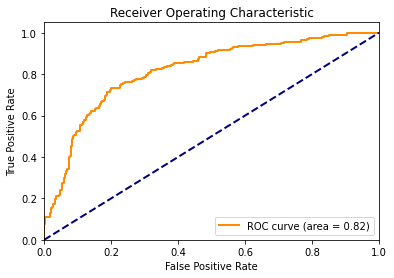

9/9 [==============================] - 1s 73ms/step - loss: 0.5098 - accuracy: 0.7500
Validation Loss: 0.5098373293876648
Validation Accuracy: 0.75
Test Loss: 0.552412948550666
Inference Time (seconds): 1.543703556060791
Test Accuracy: 0.7383333333333333
Confusion Matrix:
 [[262  40]
 [117 181]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.87      0.77       302
           1       0.82      0.61      0.70       298

    accuracy                           0.74       600
   macro avg       0.76      0.74      0.73       600
weighted avg       0.75      0.74      0.73       600

ROC AUC Score: 0.8165140672918796
Metrics saved successfully


In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [93]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 11s 322ms/step - loss: 0.4418 - accuracy: 0.8018 - val_loss: 0.5053 - val_accuracy: 0.7607
Epoch 2/150
35/35 [==============================] - 11s 315ms/step - loss: 0.4047 - accuracy: 0.8277 - val_loss: 0.5198 - val_accuracy: 0.7571
Epoch 3/150
35/35 [==============================] - 11s 317ms/step - loss: 0.3691 - accuracy: 0.8527 - val_loss: 0.5400 - val_accuracy: 0.7464
Epoch 4/150
35/35 [==============================] - 11s 316ms/step - loss: 0.3702 - accuracy: 0.8464 - val_loss: 0.5481 - val_accuracy: 0.7607
Epoch 5/150
35/35 [==============================] - 11s 316ms/step - loss: 0.3347 - accuracy: 0.8661 - val_loss: 0.5433 - val_accuracy: 0.7464
Epoch 6/150
35/35 [==============================] - 11s 316ms/step - loss: 0.3490 - accuracy: 0.8545 - val_loss: 0.5557 - val_accuracy: 0.7536
Training Time: 66.6678147315979 seconds


19/19 [==============================] - 1s 74ms/step


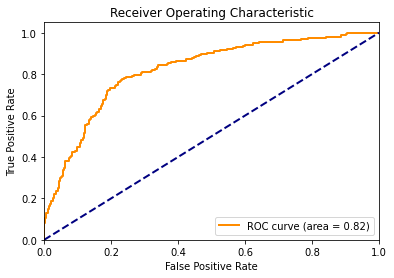

9/9 [==============================] - 1s 71ms/step - loss: 0.5053 - accuracy: 0.7607
Validation Loss: 0.5052782893180847
Validation Accuracy: 0.7607142925262451
Test Loss: 0.5402600667841844
Inference Time (seconds): 1.5515389442443848
Test Accuracy: 0.735
Confusion Matrix:
 [[253  49]
 [110 188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.76       302
           1       0.79      0.63      0.70       298

    accuracy                           0.73       600
   macro avg       0.75      0.73      0.73       600
weighted avg       0.74      0.73      0.73       600

ROC AUC Score: 0.820003111249389
Metrics saved successfully


In [94]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [95]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 11s 316ms/step - loss: 0.3853 - accuracy: 0.8375 - val_loss: 0.5128 - val_accuracy: 0.7750
Epoch 2/200
35/35 [==============================] - 11s 315ms/step - loss: 0.3952 - accuracy: 0.8286 - val_loss: 0.5728 - val_accuracy: 0.7214
Epoch 3/200
35/35 [==============================] - 11s 316ms/step - loss: 0.3676 - accuracy: 0.8438 - val_loss: 0.5109 - val_accuracy: 0.7607
Epoch 4/200
35/35 [==============================] - 11s 317ms/step - loss: 0.3392 - accuracy: 0.8643 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 5/200
35/35 [==============================] - 11s 316ms/step - loss: 0.3927 - accuracy: 0.8223 - val_loss: 0.5565 - val_accuracy: 0.7536
Epoch 6/200
35/35 [==============================] - 11s 316ms/step - loss: 0.3277 - accuracy: 0.8696 - val_loss: 0.5406 - val_accuracy: 0.7571
Epoch 7/200
35/35 [==============================] - 11s 316ms/step - loss: 0.2998 - accuracy: 0.8821 - val_loss: 0.5968 - val_accuracy:

19/19 [==============================] - 1s 68ms/step


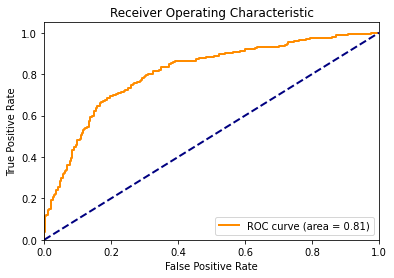

9/9 [==============================] - 1s 65ms/step - loss: 0.5109 - accuracy: 0.7607
Validation Loss: 0.5108584761619568
Validation Accuracy: 0.7607142925262451
Test Loss: 0.5482598949121043
Inference Time (seconds): 1.4252352714538574
Test Accuracy: 0.7433333333333333
Confusion Matrix:
 [[236  66]
 [ 88 210]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75       302
           1       0.76      0.70      0.73       298

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600

ROC AUC Score: 0.8071469843104138
Metrics saved successfully


In [97]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")